### 1. ИМПОРТ НЕОБХОДИМЫХ БИБЛИОТЕК

In [1]:
import random
from datetime import datetime, timedelta

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

---
#### 2. ПОДКЛЮЧЕНИЕ К БД

In [2]:
# --- 1. ПАРАМЕТРЫ ПОДКЛЮЧЕНИЯ ---
DB_USER = "postgres"
DB_PASS = "postgres"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "mipt"

# Коннект через psycopg2 для вставки
dsn = f"dbname={DB_NAME} user={DB_USER} password={DB_PASS} host={DB_HOST} port={DB_PORT}"
conn = psycopg2.connect(dsn)
cur = conn.cursor()

# SQLAlchemy engine для pandas
engine_url = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(engine_url)

---
#### 3. ГЕНЕРАЦИЯ И ВСТАВКА ДАННЫХ

In [3]:
now = datetime.utcnow()

# Генерация уникальных имен и почт с разным стилем
first_names = ["alex", "kate", "sasha", "ivan", "lena", "vlad", "dima", "olga", "misha", "anna", "elena", "sergey", "egor", "julia", "max"]
last_names = ["smirnov", "ivanov", "petrov", "sidorov", "volkov", "kozlov", "novikov", "morozov", "lebedev", "solovyov"]
domains = ["mail.ru", "gmail.com", "yandex.ru", "example.com", "test.org"]

users = []
used_usernames = set()
for _ in range(15):
    # Базовые вариации имени
    fn = random.choice(first_names)
    ln = random.choice(last_names)
    username = f"{fn}{ln}"
    while username in used_usernames:
        num = random.randint(1, 9999)
        username = f"{fn}{ln}{num}"
    used_usernames.add(username)
    domain = random.choice(domains)
    # E-mail с шансом быть не как username
    if random.random() < 0.7:
        email = f"{fn}.{ln}@{domain}"
    else:
        email = f"{username}@{domain}"
    # "Хеш" пароля
    password_hash = pd.util.hash_pandas_object(pd.Series([random.random()]), index=False).iloc[0]
    # Дата регистрации: разбросана по разным месяцам и сезонам
    created_at = now - timedelta(days=random.uniform(0, 365), seconds=random.randint(0, 86400*10))
    users.append((username, email, str(password_hash), created_at))
cur.executemany(
    "INSERT INTO mipt_project.users(username,email,password_hash,created_at) VALUES(%s,%s,%s,%s)",
    users
)
conn.commit()

# Артисты — часть "пользовательские", часть "группы"
artist_types = ["Band", "Solo", "DJ", "Composer"]
cur.execute("SELECT id FROM mipt_project.users")
user_ids = [r[0] for r in cur.fetchall()]
artists = []
used_artist_names = set()
for _ in range(15):
    t = random.choice(artist_types)
    if t == "Band":
        name = f"The {random.choice(last_names).capitalize()}s"
    elif t == "DJ":
        name = f"DJ {random.choice(first_names).capitalize()}{random.randint(1, 99)}"
    elif t == "Composer":
        name = f"{random.choice(first_names).capitalize()} {random.choice(last_names).capitalize()}"
    else:
        name = f"{random.choice(first_names).capitalize()}_{random.randint(100,999)}"
    while name in used_artist_names:
        name = f"{name}_{random.randint(1,999)}"
    used_artist_names.add(name)
    bio = f"{t} from {random.choice(['Moscow', 'Berlin', 'London', 'Paris', 'Tokyo', 'New York', 'LA'])}. Bio ID {random.randint(1000,9999)}"
    user_id = random.choice(user_ids)
    created_at = now - timedelta(days=random.uniform(0, 365), seconds=random.randint(0, 86400*20))
    artists.append((name, bio, user_id, created_at))
cur.executemany(
    "INSERT INTO mipt_project.artists(name,bio,user_id,created_at) VALUES(%s,%s,%s,%s)",
    artists
)
conn.commit()

# Альбомы — разные годы, иногда с "Deluxe"
cur.execute("SELECT id FROM mipt_project.artists")
artist_ids = [r[0] for r in cur.fetchall()]
albums = []
for _ in range(20):
    artist_id = random.choice(artist_ids)
    base = f"{random.choice(['Blue', 'Red', 'Golden', 'Secret', 'Night', 'Summer', 'Lost', 'Magic'])}"
    suffix = random.choice(["", " Deluxe", " Edition", " Live"]) if random.random() < 0.3 else ""
    title = f"{base} Album{suffix} {random.randint(1, 30)}"
    release_date = datetime(random.randint(2019, 2024), random.randint(1, 12), random.randint(1, 28))
    created_at = release_date - timedelta(days=random.randint(0, 100))
    albums.append((artist_id, title, release_date, created_at))
cur.executemany(
    "INSERT INTO mipt_project.albums(artist_id,title,release_date,created_at) VALUES(%s,%s,%s,%s)",
    albums
)
conn.commit()

# Жанры — если их ещё нет, создаём и заполняем
genre_names = [
    "Pop", "Rock", "Jazz", "Classical", "Electronic", "Hip-Hop", "Metal", "Indie", "Folk", "Reggae", "Blues",
    "Funk", "Disco", "Country", "Techno", "House", "Trance"
]
cur.execute("SELECT COUNT(*) FROM mipt_project.genres")
if cur.fetchone()[0] < len(genre_names):
    genres = [(g, f"Description for {g}") for g in genre_names]
    cur.executemany(
        "INSERT INTO mipt_project.genres(name,description) VALUES(%s,%s) ON CONFLICT DO NOTHING",
        genres
    )
    conn.commit()

# Треки — по альбомам, с уникальными названиями и разной длительностью
cur.execute("SELECT id FROM mipt_project.albums")
album_ids = [r[0] for r in cur.fetchall()]
tracks = []
for aid in album_ids:
    # Генерируем 4-7 треков на альбом, все с уникальными номерами
    n_tracks = random.randint(4, 7)
    for tn in range(1, n_tracks+1):
        name = f"Track_{random.choice(['Dream', 'Fire', 'Rain', 'Sun', 'Moon', 'Night', 'Light', 'Sky'])}_{tn}"
        duration = random.randint(100, 520)
        url = f"https://audio.example.com/{random.getrandbits(40):x}.mp3"
        created_at = now - timedelta(days=random.uniform(0, 180), seconds=random.randint(0, 86400*10))
        tracks.append((aid, name, duration, tn, url, created_at))
cur.executemany(
    """
    INSERT INTO mipt_project.tracks
      (album_id, title, duration, track_number, track_url, created_at)
    VALUES (%s, %s, %s, %s, %s, %s)
    ON CONFLICT (album_id, track_number) DO NOTHING
    """,
    tracks
)
conn.commit()

# Плейлисты — часть общих, часть пользовательских
cur.execute("SELECT id FROM mipt_project.users")
user_ids = [r[0] for r in cur.fetchall()]
playlists = []
for _ in range(20):
    user_id = random.choice(user_ids)
    title = random.choice([
        "Roadtrip", "Chillout", "Workout", "Study Vibes", "Party Hits", "Relax", "Morning Boost", "Sleep Time"
    ]) + f" {random.randint(1, 99)}"
    description = f"Playlist for {random.choice(['fun', 'focus', 'energy', 'relaxation', 'travel', 'work'])}"
    created_at = now - timedelta(days=random.uniform(0, 365), seconds=random.randint(0, 86400*10))
    playlists.append((user_id, title, description, created_at))
cur.executemany(
    "INSERT INTO mipt_project.playlists(user_id,title,description,created_at) VALUES(%s,%s,%s,%s)",
    playlists
)
conn.commit()

# Track-Genres (каждому треку — 1-3 жанра)
cur.execute("SELECT id FROM mipt_project.tracks")
track_ids = [r[0] for r in cur.fetchall()]
cur.execute("SELECT id FROM mipt_project.genres")
genre_ids = [r[0] for r in cur.fetchall()]
tg_rel = []
for tid in track_ids:
    k = random.randint(1, min(3, len(genre_ids)))
    for gid in random.sample(genre_ids, k=k):
        tg_rel.append((tid, gid))
cur.executemany(
    "INSERT INTO mipt_project.track_genres(track_id,genre_id) VALUES(%s,%s) ON CONFLICT DO NOTHING",
    tg_rel
)
conn.commit()

# Playlist-Tracks (3-8 треков в каждом плейлисте, уникальных, позиции перемешаны)
cur.execute("SELECT id FROM mipt_project.playlists")
pl_ids = [r[0] for r in cur.fetchall()]
pt_rel = []
for pid in pl_ids:
    sel = random.sample(track_ids, k=random.randint(3, 8))
    random.shuffle(sel)
    for pos, tid in enumerate(sel, start=1):
        pt_rel.append((pid, tid, pos))
cur.executemany(
    "INSERT INTO mipt_project.playlist_tracks(playlist_id,track_id,position) VALUES(%s,%s,%s) ON CONFLICT DO NOTHING",
    pt_rel
)
conn.commit()

---
#### 4. АНАЛИТИЧЕСКИЕ ВЫБОРКИ

In [4]:
albums_df = pd.read_sql("SELECT id, title FROM mipt_project.albums", con=engine)
tracks_df = pd.read_sql(
    "SELECT id AS track_id, album_id, duration FROM mipt_project.tracks", con=engine
)
track_genres_df = pd.read_sql(
    "SELECT track_id, genre_id FROM mipt_project.track_genres", con=engine
)
genres_df = pd.read_sql(
    "SELECT id AS genre_id, name FROM mipt_project.genres", con=engine
)
playlists_df = pd.read_sql(
    "SELECT id AS playlist_id, user_id FROM mipt_project.playlists", con=engine
)
users_df = pd.read_sql(
    "SELECT id AS user_id, username FROM mipt_project.users", con=engine
)

tracks_per_album = (
    tracks_df.groupby('album_id')
    .size()
    .reset_index(name='track_count')
    .merge(albums_df, left_on='album_id', right_on='id')
)

tg = track_genres_df.merge(genres_df, on='genre_id')
tracks_per_genre = (
    tg.groupby('name')
    .size()
    .reset_index(name='track_count')
)

pl_per_user = (
    playlists_df.groupby('user_id')
    .size()
    .reset_index(name='playlists_count')
    .merge(users_df, on='user_id')
)


---
#### 5. ВИЗУАЛИЗАЦИЯ

C:\Users\rodin\AppData\Local\Temp\ipykernel_5100\1997124808.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='track_count', y='name', data=top5, palette='viridis')


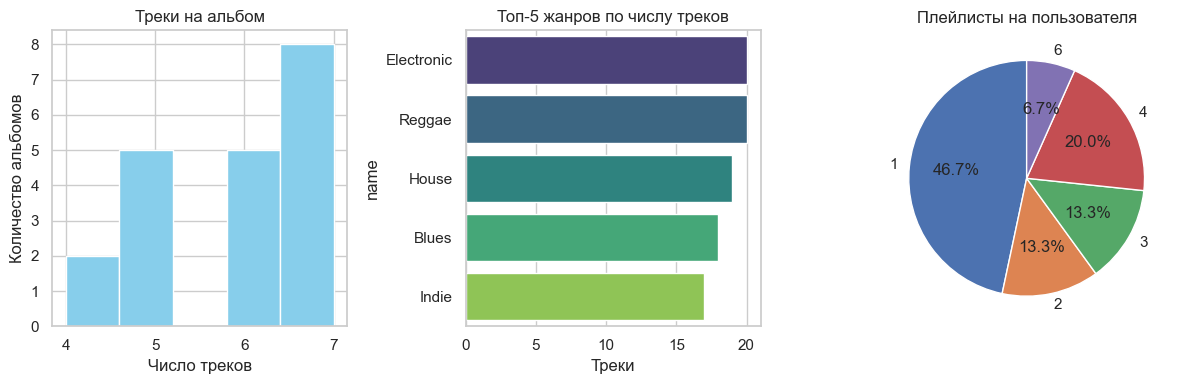

In [5]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 4))

# Гистограмма треков на альбом
plt.subplot(1, 3, 1)
tracks_per_album['track_count'].hist(bins=5, color='skyblue')
plt.title('Треки на альбом')
plt.xlabel('Число треков')
plt.ylabel('Количество альбомов')

# Столбчатая диаграмма топ-5 жанров
plt.subplot(1, 3, 2)
top5 = tracks_per_genre.sort_values('track_count', ascending=False).head(5)
sns.barplot(x='track_count', y='name', data=top5, palette='viridis')
plt.title('Топ-5 жанров по числу треков')
plt.xlabel('Треки')

# Круговая диаграмма плейлистов на пользователя
plt.subplot(1, 3, 3)
cnts = pl_per_user['playlists_count'].value_counts().sort_index()
plt.pie(cnts, labels=cnts.index.astype(str),
        autopct='%1.1f%%', startangle=90)
plt.title('Плейлисты на пользователя')

plt.tight_layout()
plt.savefig('analysis_plots.png')
plt.show()

---
#### 6. ПРОВЕРКА ГИПОТЕЗ

In [6]:
print("Гипотеза 1: Среднее число треков на альбом > 1")
avg_tracks = tracks_per_album['track_count'].mean()
print(f"Среднее: {avg_tracks:.2f}")
print("Подтверждена" if avg_tracks > 1 else "Не подтверждена")

print("\nГипотеза 2: Есть хотя бы один пользователь с более чем одним плейлистом")
multi_playlist_users = (pl_per_user['playlists_count'] > 1).any()
print("Подтверждена" if multi_playlist_users else "Не подтверждена")

print("\nГипотеза 3: Жанр 'Rock' лидирует по числу треков")
rock_count = tracks_per_genre.set_index('name').at['Rock', 'track_count']
max_other = tracks_per_genre[tracks_per_genre.name != 'Rock']['track_count'].max()
print(f"Rock: {rock_count}, Max остальных: {max_other}")
print("Подтверждена" if rock_count > max_other else "Не подтверждена")

Гипотеза 1: Среднее число треков на альбом > 1
Среднее: 5.95
Подтверждена

Гипотеза 2: Есть хотя бы один пользователь с более чем одним плейлистом
Подтверждена

Гипотеза 3: Жанр 'Rock' лидирует по числу треков
Rock: 13, Max остальных: 20
Не подтверждена


---
#### 5. ВЫВОДЫ

In [7]:
print("\nВыводы:")
print(f"1. Среднее число треков на альбом: {avg_tracks:.2f}.")
print("   - Гипотеза 1 " + ("верна." if avg_tracks > 1 else "ложна."))
print(f"2. Пользователи с более чем одним плейлистом: {'есть' if multi_playlist_users else 'нет'}.")
print("   - Гипотеза 2 " + ("верна." if multi_playlist_users else "ложна."))
print(f"3. Жанр 'Rock' {'лидирует' if rock_count > max_other else 'не лидирует'} по числу треков.")
print("   - Гипотеза 3 " + ("верна." if rock_count > max_other else "ложна."))


Выводы:
1. Среднее число треков на альбом: 5.95.
   - Гипотеза 1 верна.
2. Пользователи с более чем одним плейлистом: есть.
   - Гипотеза 2 верна.
3. Жанр 'Rock' не лидирует по числу треков.
   - Гипотеза 3 ложна.


---
#### 6. ЗАКРЫВАЕМ СОЕДИНЕНИЕ

In [8]:
conn.close()